In [106]:
%reset
import pandas as pd
import os
from scipy.stats import ttest_ind
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# January Effect

In [107]:
def calculate_monthly_returns(df):
    df['Date'] = pd.to_datetime(df['TradingDate'], format='%d/%m/%Y')
    df.set_index('Date', inplace=True)
    monthly_returns = df['Close'].resample('M').ffill().pct_change()
    return monthly_returns

def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data > lower_bound) & (data < upper_bound)]

In [108]:
directory = '/Users/juss/Documents/GitHub/data_mining_project/Data/Timeseries_Data'

# List to store results
all_january_returns = []
all_other_month_returns = []

In [109]:
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        stock_data = pd.read_csv(file_path)
        monthly_returns = calculate_monthly_returns(stock_data)
        january_returns = monthly_returns[monthly_returns.index.month == 1]
        other_month_returns = monthly_returns[monthly_returns.index.month != 1]
        all_january_returns.extend(january_returns.dropna().tolist())
        all_other_month_returns.extend(other_month_returns.dropna().tolist())

In [110]:
january_returns_array = np.array(all_january_returns)
other_month_returns_array = np.array(all_other_month_returns)

filtered_january_returns = remove_outliers(january_returns_array)
filtered_other_month_returns = remove_outliers(other_month_returns_array)

if filtered_january_returns.size > 0 and filtered_other_month_returns.size > 0:
    january_effect, p_value = ttest_ind(filtered_january_returns, filtered_other_month_returns, equal_var=False)
    print("T-statistic for January Effect:", january_effect)
    print("P-value:", p_value)
else:
    print("Insufficient data for T-test after filtering extremes.")

T-statistic for January Effect: -6.328814008150433
P-value: 3.1807735871767724e-10


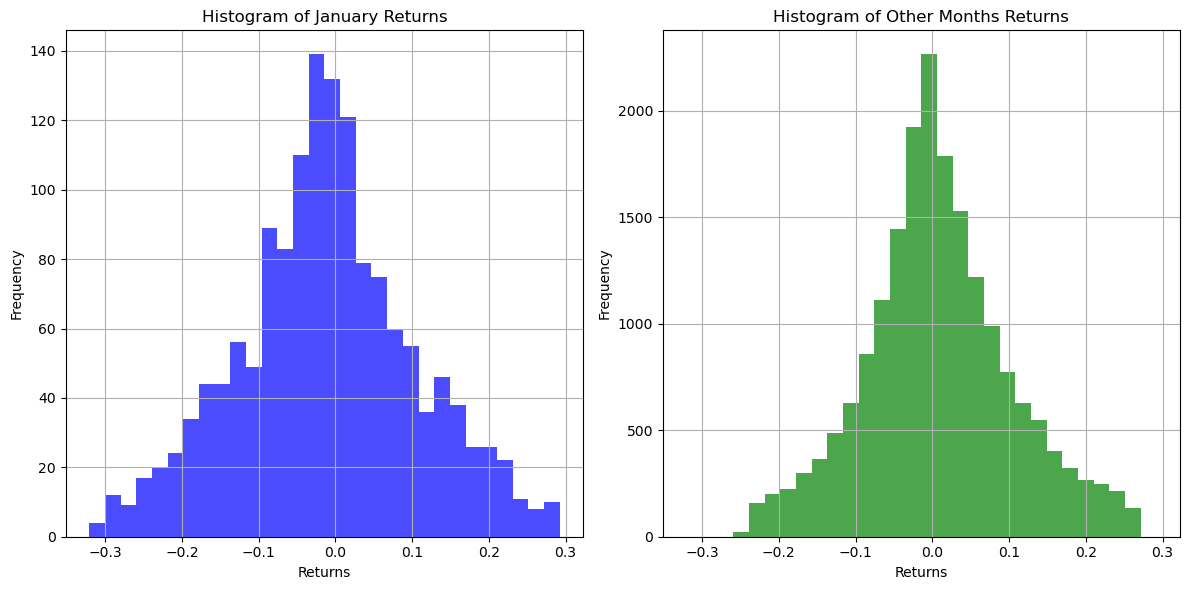

In [112]:
df_1 = pd.DataFrame({
    'January Returns': pd.Series(filtered_january_returns),
    'Other Month Returns': pd.Series(filtered_other_month_returns)
})

# Determine the common range for the histograms
common_range = (min(df_1.min()), max(df_1.max()))

# Plotting histograms
plt.figure(figsize=(12, 6))

# Histogram for January Returns
plt.subplot(1, 2, 1)
plt.hist(df_1['January Returns'], bins=30, alpha=0.7, color='blue', range=common_range)
plt.title('Histogram of January Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)

# Histogram for Other Months' Returns
plt.subplot(1, 2, 2)
plt.hist(df_1['Other Month Returns'], bins=30, alpha=0.7, color='green', range=common_range)
plt.title('Histogram of Other Months Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

# Weekend Effect
- The weekend effect describes the tendency of stock prices to decrease on Mondays, meaning that closing prices on Monday are lower than closing prices on the previous Friday.

In [113]:
def calculate_daily_returns(df):
    df['Date'] = pd.to_datetime(df['TradingDate'], format='%d/%m/%Y')
    df.set_index('Date', inplace=True)
    daily_returns = df['Close'].pct_change()
    return daily_returns

In [114]:
# List to store results
monday_returns = []
friday_returns = []

In [115]:
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        stock_data = pd.read_csv(file_path)
        daily_returns = calculate_daily_returns(stock_data)

        # Filter and clean returns by day of the week
        monday_data = daily_returns[daily_returns.index.weekday == 0].dropna()
        friday_data = daily_returns[daily_returns.index.weekday == 4].dropna()

        # Remove outliers using IQR
        clean_monday_returns = remove_outliers(monday_data)
        clean_friday_returns = remove_outliers(friday_data)

        monday_returns.extend(clean_monday_returns.tolist())
        friday_returns.extend(clean_friday_returns.tolist())

In [116]:
# Convert lists to numpy arrays
monday_returns_array = np.array(monday_returns)
friday_returns_array = np.array(friday_returns)

# Check for zero variance and perform the T-test if data is sufficient
if len(monday_returns_array) > 0 and np.var(monday_returns_array) != 0 and \
   len(friday_returns_array) > 0 and np.var(friday_returns_array) != 0:
    monday_effect_stat, monday_effect_p_value = ttest_ind(monday_returns_array, friday_returns_array, equal_var=False)
    print("T-statistic for Monday Effect:", monday_effect_stat)
    print("P-value for Monday Effect:", monday_effect_p_value)
else:
    print("Insufficient data or zero variance detected, invalidating the T-test.")

T-statistic for Monday Effect: -14.001502893962012
P-value for Monday Effect: 1.6308270105189766e-44


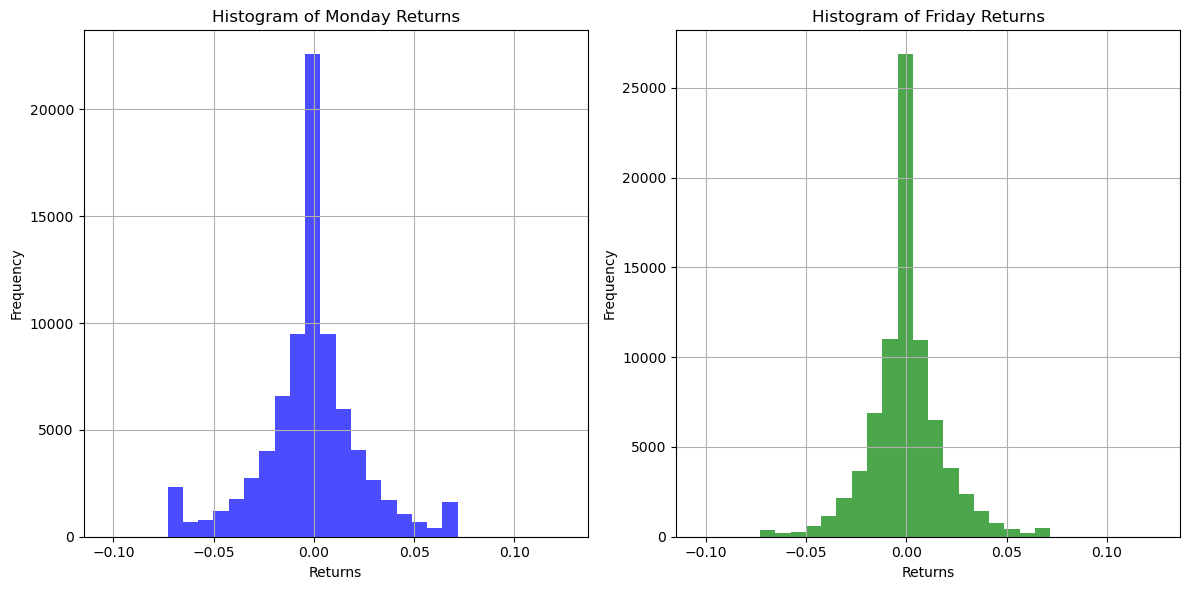

In [117]:
df_2 = pd.DataFrame({
    'Monday Returns': pd.Series(monday_returns_array),
    'Friday Returns': pd.Series(friday_returns_array)
})

# Determine the common range for the histograms
common_range = (min(df_2.min()), max(df_2.max()))

# Plotting histograms
plt.figure(figsize=(12, 6))

# Histogram for January Returns
plt.subplot(1, 2, 1)
plt.hist(df_2['Monday Returns'], bins=30, alpha=0.7, color='blue', range=common_range)
plt.title('Histogram of Monday Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)

# Histogram for Other Months' Returns
plt.subplot(1, 2, 2)
plt.hist(df_2['Friday Returns'], bins=30, alpha=0.7, color='green', range=common_range)
plt.title('Histogram of Friday Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

# Turn-of-the-month Effect

In [101]:
# List to store results
turn_of_month_returns = []
other_returns = []

In [102]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [103]:
# Process each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        df_3 = pd.read_csv(file_path)
        df_3['Date'] = pd.to_datetime(df_3['TradingDate'], format='%d/%m/%Y')
        df_3.set_index('Date', inplace=True)

        # Calculate daily returns
        df_3['Returns'] = df_3['Close'].pct_change().dropna()
        
        df_3 = remove_outliers(df_3, 'Returns')

        # Identify turn-of-the-month days
        df_3['Month'] = df_3.index.month
        turn_of_month = df_3[
            (df_3.index.is_month_end) | 
            (df_3.index.shift(-1, freq='B').month != df_3['Month']) |  # First business day
            (df_3.index.shift(-2, freq='B').month != df_3['Month']) |  # Second business day
            (df_3.index.shift(-3, freq='B').month != df_3['Month'])    # Third business day
        ]

        # Filter returns for turn-of-the-month and other days
        if not turn_of_month.empty:
            turn_of_month_returns.extend(turn_of_month['Returns'].tolist())
        other_days = df_3.loc[~df_3.index.isin(turn_of_month.index), 'Returns']
        if not other_days.empty:
            other_returns.extend(other_days.tolist())

In [104]:
# Convert lists to numpy arrays
turn_of_month_returns_array = np.array(turn_of_month_returns)
other_returns_array = np.array(other_returns)

# Remove any remaining NaN values
turn_of_month_returns_array = turn_of_month_returns_array[~np.isnan(turn_of_month_returns_array)]
other_returns_array = other_returns_array[~np.isnan(other_returns_array)]

print(max(turn_of_month_returns_array))
print(min(turn_of_month_returns_array))



0.1071428571428572
-0.09523809523809523


In [105]:
# Perform the T-test if sufficient data exists
if len(turn_of_month_returns_array) > 0 and len(other_returns_array) > 0:
    stat, p_value = ttest_ind(turn_of_month_returns_array, other_returns_array, equal_var=False)
    print("T-statistic for Turn-of-the-Month Effect across all stocks:", stat)
    print("P-value for Turn-of-the-Month Effect across all stocks:", p_value)
else:
    print("Insufficient data for testing")

T-statistic for Turn-of-the-Month Effect across all stocks: 14.368815846207733
P-value for Turn-of-the-Month Effect across all stocks: 9.206851525617967e-47
